# Final Project-- Kaggle Competition
### Name: Yixiao Wang
### Kaggle ID: YixiaoWang0102

## 0. Basic Preparation

**P.S.** Hi TAs, Thank you for all your hard work throughout this course!
Please note that some file paths in the document include prefixes from my Colab environment. These prefixes (e.g., /content/drive/My Drive/Colab Notebooks/final_project/) should be removed or adjusted as they refer to my personal working directory in Google Colab.

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
!pip install optuna
!pip install googletrans
!pip install langdetect
!pip install sweetviz

  Using cached langdetect-1.0.9-py3-none-any.whl


In [4]:
# Import general libraries
import pandas as pd
import numpy as np
from datetime import datetime
from tqdm import tqdm
import re
import matplotlib.pyplot as plt
import seaborn as sns

# Import NLP-related libraries
from nltk.stem.porter import PorterStemmer
from nltk.tokenize import word_tokenize
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.decomposition import LatentDirichletAllocation
from langdetect import detect
from googletrans import Translator

# Sentence embeddings and clustering
from sentence_transformers import SentenceTransformer
from sklearn.cluster import KMeans

# Machine Learning libraries
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import AdaBoostRegressor
from sklearn.svm import SVR
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor
from sklearn.impute import SimpleImputer
from sklearn.model_selection import train_test_split, KFold
from sklearn.metrics import mean_squared_error
from sklearn.inspection import permutation_importance
from sklearn.preprocessing import StandardScaler

# Optimization library
import optuna

# Statistical utilities
from scipy.stats import mode

# Visualization libraries
import plotly.graph_objects as go
import sweetviz as sv
from IPython.display import HTML


/usr/local/lib/python3.10/dist-packages/dask/dataframe/__init__.py:42: FutureWarning: 
Dask dataframe query planning is disabled because dask-expr is not installed.

You can install it with `pip install dask[dataframe]` or `conda install dask`.
This will raise in a future version.

  warnings.warn(msg, FutureWarning)


## 1. Data Download

In [20]:
# This is the original data, but the LDA process is quite lengthy, so we saved the original data with the LDA results included.
# The LDA code is provided in the preprocessing section but has been commented out.import pandas as pd
# train_data = pd.read_csv('/content/drive/My Drive/Colab Notebooks/final_project/train_LDA.csv', parse_dates=['host_since', 'first_review', 'last_review'])
# test_data = pd.read_csv('/content/drive/My Drive/Colab Notebooks/final_project/test_LDA.csv', parse_dates=['host_since', 'first_review', 'last_review'])

train_data = pd.read_csv('/content/drive/My Drive/Colab Notebooks/final_project/train_LDA.csv')
test_data = pd.read_csv('/content/drive/My Drive/Colab Notebooks/final_project/test_LDA.csv')
# 将列转换为 datetime 类型
date_columns = ['host_since', 'first_review', 'last_review']
for col in date_columns:
    if col in train_data.columns:
        train_data[col] = pd.to_datetime(train_data[col], errors='coerce')

for col in date_columns:
    if col in test_data.columns:
        test_data[col] = pd.to_datetime(test_data[col], errors='coerce')


In [6]:
# This is the processed amenities mapping used for analyzing amenities, which is based on train_data
# and includes the parts I manually handled, so it can be directly imported.
# The categories for numbering are roughly as follows:
# 0: Entertainment and networking facilities, such as wifi, TV, Bluetooth speakers
# 1: Safety-related items, such as locker, alarm
# 2: Kitchen-related items, such as oven, refrigerator
# 3: Daily necessities, such as shampoo, conditioner
# 4: Sports and health facilities, such as gym, pool
# 5: Additional or paid services
# 6: Family- or baby-friendly facilities
# 7: Unclear classifications, such as information related to days of the week
amenities_df = pd.read_excel("/content/drive/My Drive/Colab Notebooks/final_project/processed_amenities_cluster_mapping.xlsx")
amenities_cluster_mapping = dict(zip(amenities_df['amenity'], amenities_df['cluster_id']))
print("First 10 items in amenities_cluster_mapping:")
for i, (key, value) in enumerate(amenities_cluster_mapping.items()):
    print(f"{key}: {value}")
    if i == 10:
        break

First 10 items in amenities_cluster_mapping:
Dishwasher: 2
Single level home: 3
Stove: 2
Smoke alarm: 1
49 inch HDTV with Amazon Prime Video: 0
Apple TV: 0
Disney+: 0
HBO Max: 0
Hulu: 0
Netflix: 0
Roku: 0


## 2. EDA

In [13]:
# # Create a report
# report = sv.analyze(train_data)

# # Save the report as an HTML file
# report.show_html("/content/drive/My Drive/Colab Notebooks/final_project/train_data_distribution.html")

# Load the HTML file content
with open("/content/drive/My Drive/Colab Notebooks/final_project/train_data_distribution.html", "r") as f:
    html_content = f.read()

# Display the report directly in Colab
HTML(html_content)


Output hidden; open in https://colab.research.google.com to view.

In [14]:
# Select only numerical columns from train_data
numerical_columns = train_data.select_dtypes(include=[np.number])

# Calculate the correlation matrix
correlation_matrix = numerical_columns.corr()

# Plot the correlation matrix using seaborn
plt.figure(figsize=(40, 30))
sns.heatmap(correlation_matrix, annot=True, fmt=".2f", cmap="coolwarm", cbar=True, square=True)
plt.title("Correlation Matrix of Numerical Features", fontsize=16)
plt.xticks(rotation=45, ha='right')
plt.yticks(rotation=0)
plt.show()

Output hidden; open in https://colab.research.google.com to view.

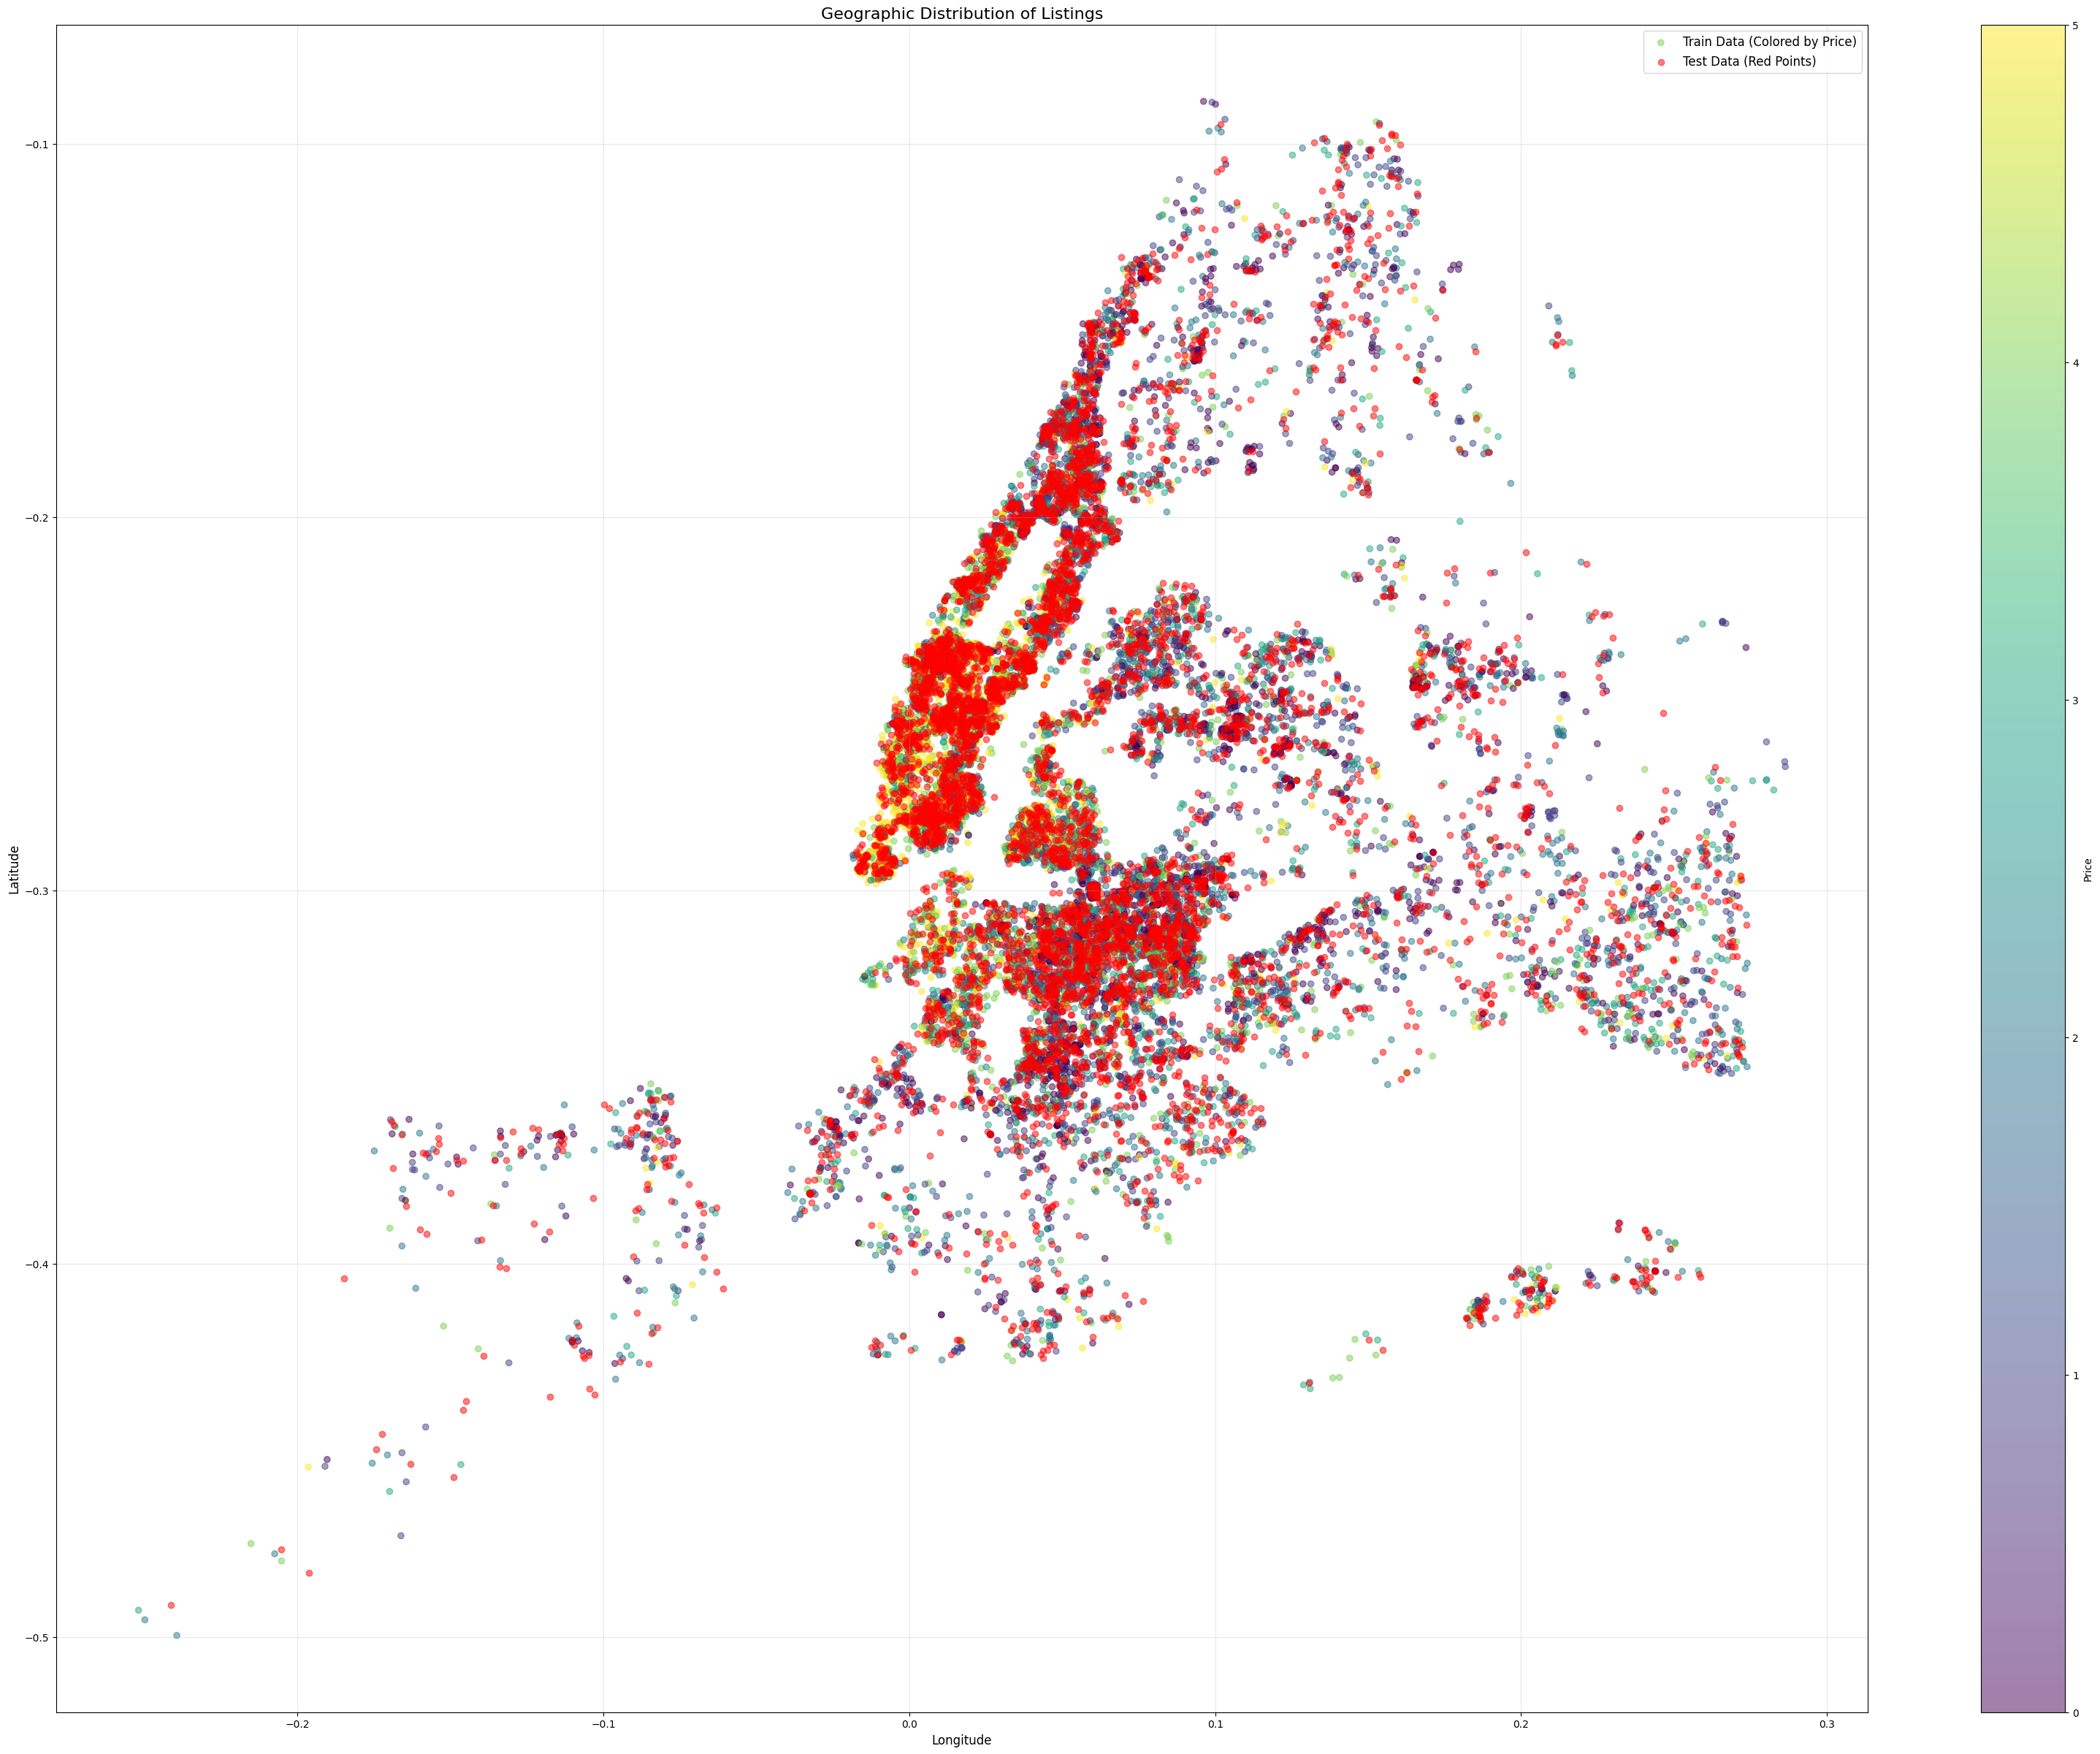

In [19]:
import matplotlib.pyplot as plt

# We will mark the `test_data` dataset in red and visualize `train_data` with price as the color scale
# to check if the distribution is even.

# Set the figure size
plt.figure(figsize=(40, 30))

# Plot the scatter plot for `train_data`, with price represented by color
scatter_train = plt.scatter(
    train_data['longitude'],   # Longitude data
    train_data['latitude'],    # Latitude data
    c=train_data['price'],     # Price data for color
    cmap='viridis',            # Use `viridis` colormap
    alpha=0.5,                 # Set transparency
    label='Train Data (Colored by Price)'  # Legend label
)

# Plot the scatter plot for `test_data`, marked in red
plt.scatter(
    test_data['longitude'],    # Longitude data
    test_data['latitude'],     # Latitude data
    color='red',               # Use red color for points
    alpha=0.5,                 # Set transparency
    label='Test Data (Red Points)'  # Legend label
)

# Add a color bar to show the price scale
plt.colorbar(scatter_train, label='Price')

# Add title and axis labels
plt.title('Geographic Distribution of Listings', fontsize=16)  # Set the title
plt.xlabel('Longitude', fontsize=12)  # Set X-axis label
plt.ylabel('Latitude', fontsize=12)   # Set Y-axis label

# Display grid lines for better readability
plt.grid(alpha=0.3)

# Add legend
plt.legend(fontsize=12)

# Show the plot
plt.show()


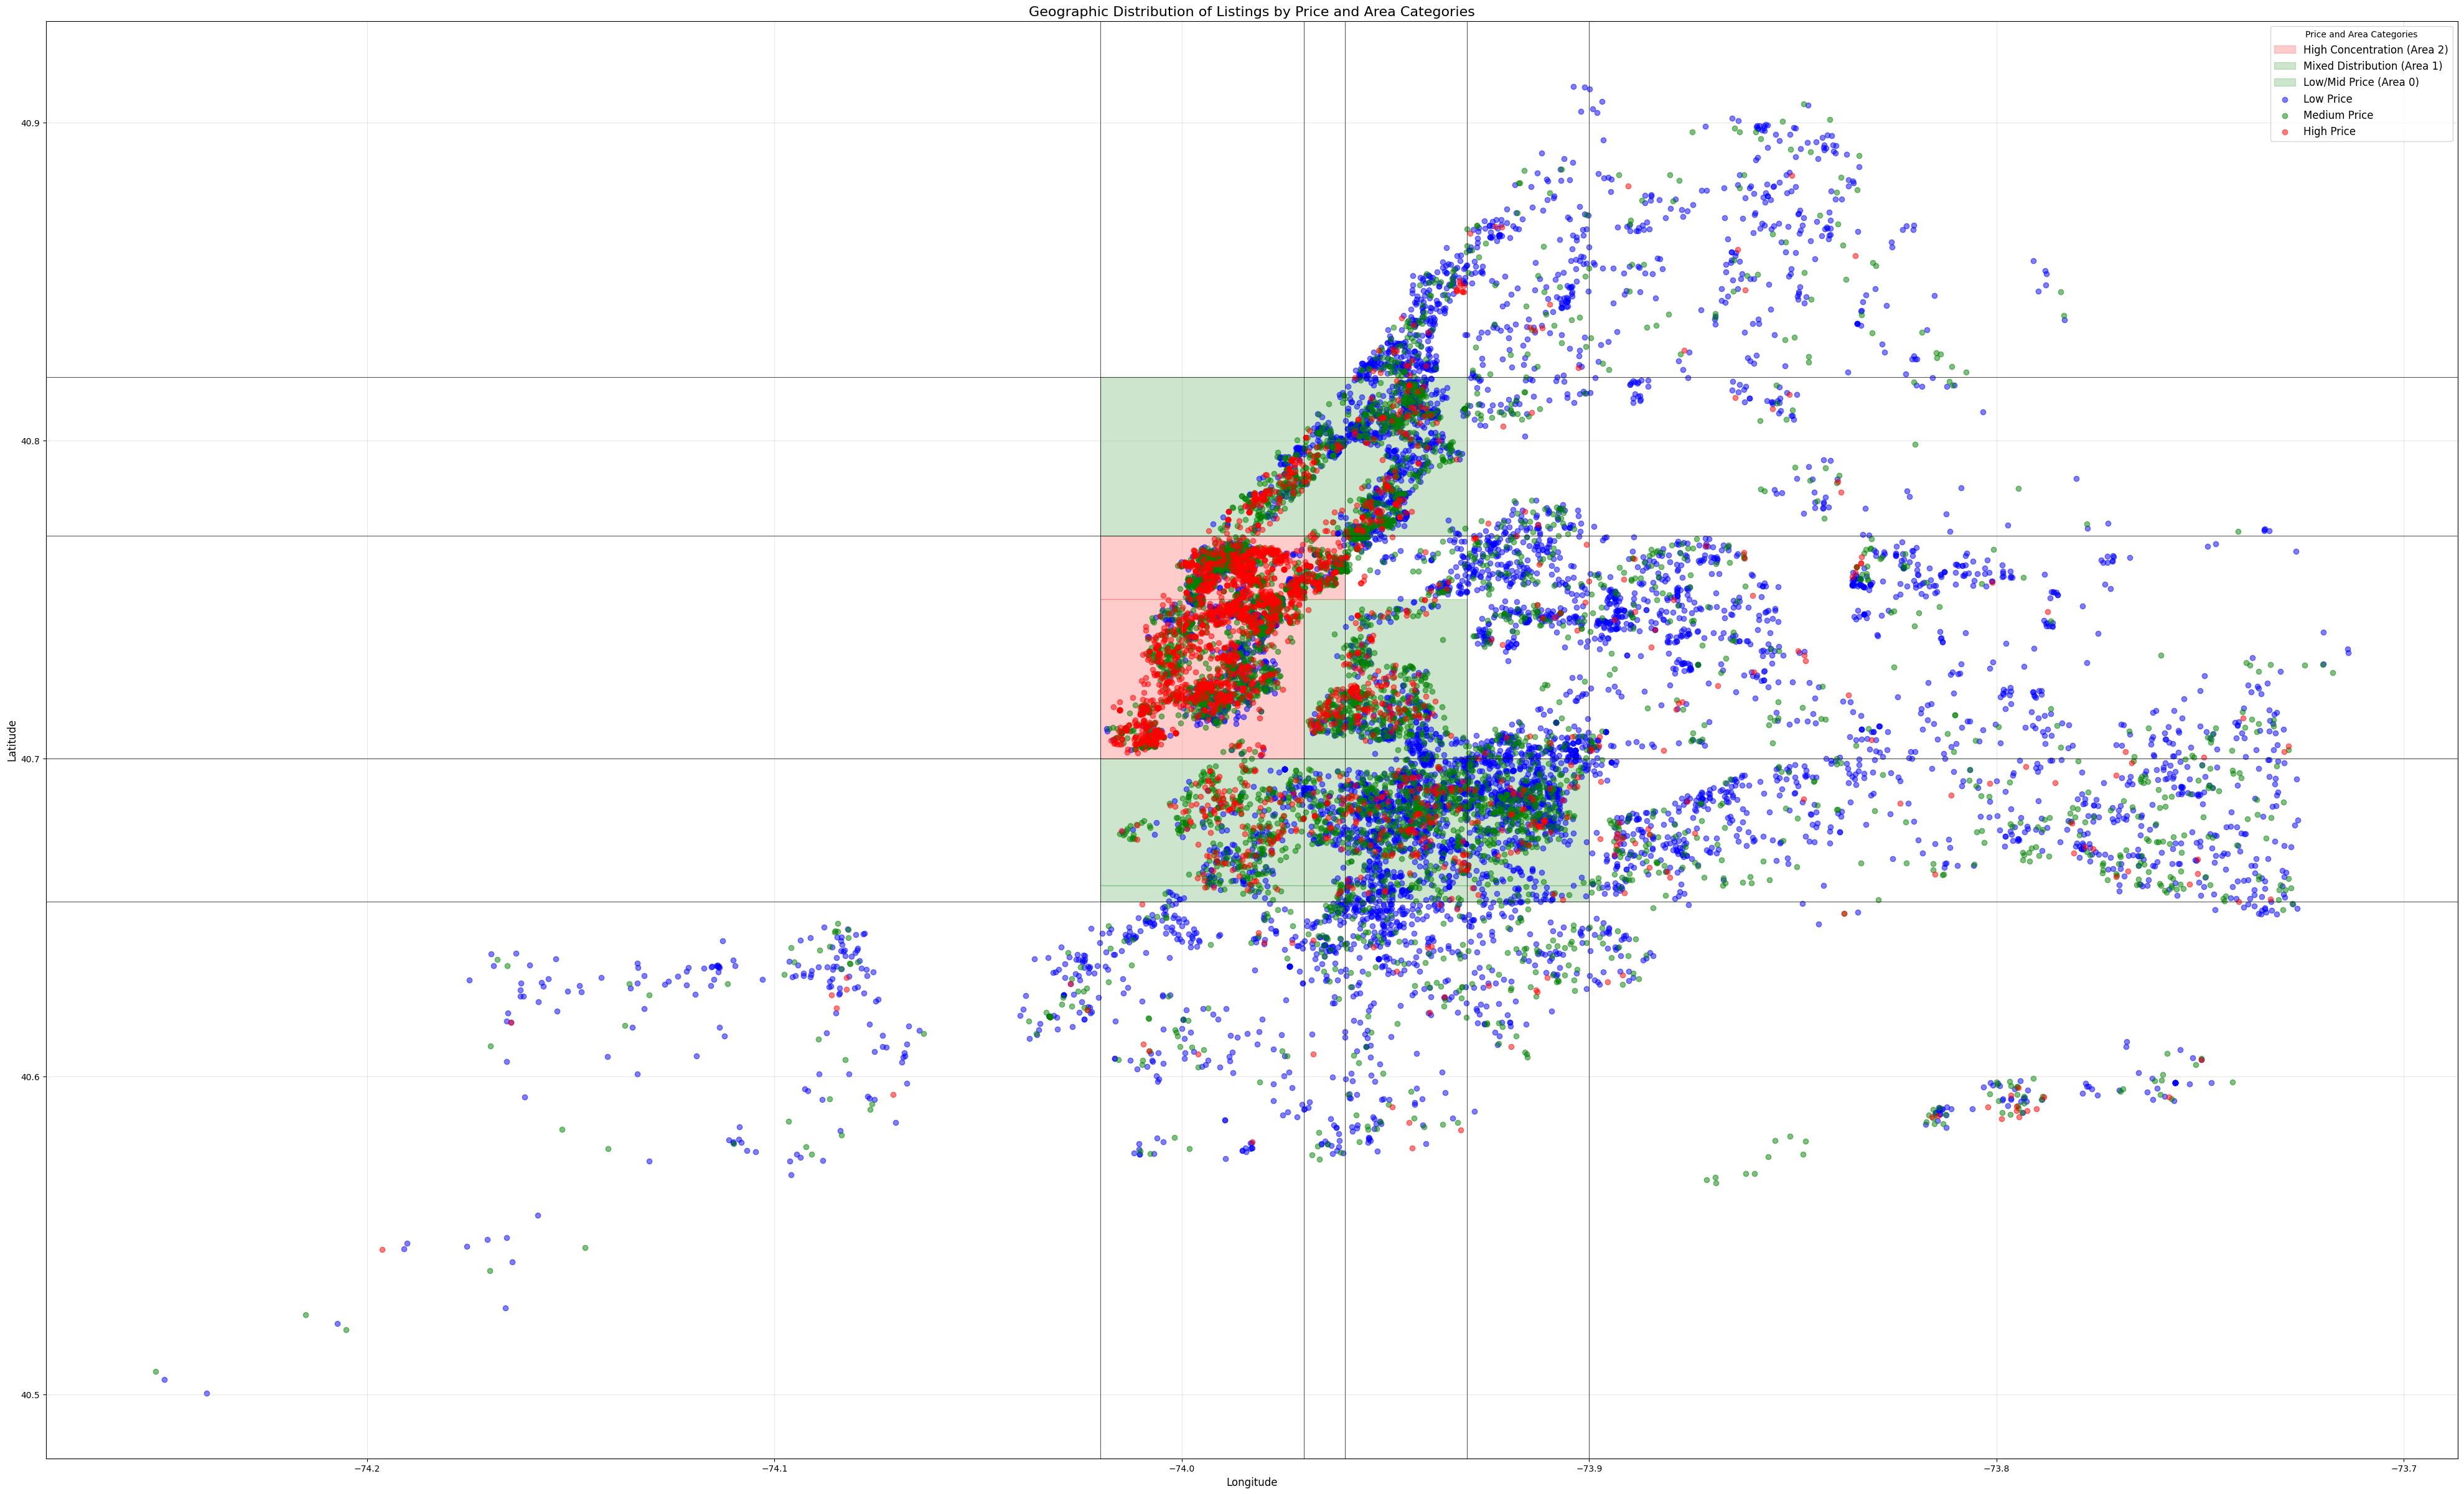

In [24]:
import matplotlib.pyplot as plt
import numpy as np

# Define the function to assign area categories (already defined above)
def assign_area_category(row):
    if (
        (40.75 <= row['latitude'] <= 40.77 and -74.02 <= row['longitude'] < -73.96) or
        (40.7 <= row['latitude'] <= 40.75 and -74.02 <= row['longitude'] < -73.97)
    ):
        return 2
    elif (
        (40.77 <= row['latitude'] <= 40.82 and -74.02 <= row['longitude'] < -73.93) or
        (40.7 <= row['latitude'] <= 40.75 and -73.97 <= row['longitude'] < -73.93) or
        (40.66 <= row['latitude'] <= 40.7 and -74.02 <= row['longitude'] < -73.9)
    ):
        return 1
    else:
        return 0

# Apply area category assignment to the dataset
train_data['area_category'] = train_data.apply(assign_area_category, axis=1)

# Plot data with area overlays
plt.figure(figsize=(50, 30))

# Define colors for area overlays
area_colors = {2: 'red', 1: 'green', 0: 'blue'}
area_labels = {2: 'High Concentration (Area 2)', 1: 'Mixed Distribution (Area 1)', 0: 'Low/Mid Price (Area 0)'}

# Add region overlays
plt.fill_betweenx(y=[40.75, 40.77], x1=-74.02, x2=-73.96, color='red', alpha=0.2, label=area_labels[2])
plt.fill_betweenx(y=[40.7, 40.75], x1=-74.02, x2=-73.97, color='red', alpha=0.2)

plt.fill_betweenx(y=[40.77, 40.82], x1=-74.02, x2=-73.93, color='green', alpha=0.2, label=area_labels[1])
plt.fill_betweenx(y=[40.7, 40.75], x1=-73.97, x2=-73.93, color='green', alpha=0.2)
plt.fill_betweenx(y=[40.66, 40.7], x1=-74.02, x2=-73.9, color='green', alpha=0.2)

plt.fill_betweenx(y=[40.655, 40.66], x1=-74.02, x2=-73.9, color='green', alpha=0.2, label=area_labels[0])

# Plot data points
for category, color in color_mapping.items():
    subset = train_data[train_data['price_category'] == category]
    plt.scatter(
        subset['longitude'],
        subset['latitude'],
        c=color,
        alpha=0.5,
        label=f'{category} Price'
    )

# Add gridlines for reference
plt.axhline(y=40.7, color='black', linestyle='-', linewidth=0.5)
plt.axhline(y=40.77, color='black', linestyle='-', linewidth=0.5)
plt.axhline(y=40.82, color='black', linestyle='-', linewidth=0.5)
plt.axhline(y=40.655, color='black', linestyle='-', linewidth=0.5)
plt.axvline(x=-73.9, color='black', linestyle='-', linewidth=0.5)
plt.axvline(x=-73.97, color='black', linestyle='-', linewidth=0.5)
plt.axvline(x=-73.93, color='black', linestyle='-', linewidth=0.5)
plt.axvline(x=-74.02, color='black', linestyle='-', linewidth=0.5)
plt.axvline(x=-73.96, color='black', linestyle='-', linewidth=0.5)

# Add legend
plt.legend(title='Price and Area Categories', fontsize=12)

# Add title and labels
plt.title('Geographic Distribution of Listings by Price and Area Categories', fontsize=16)
plt.xlabel('Longitude', fontsize=12)
plt.ylabel('Latitude', fontsize=12)

# Display grid
plt.grid(alpha=0.3)

# Show the plot
plt.show()


## 3.Feature Engineering

In [7]:
# Initialize PorterStemmer
stemmer = PorterStemmer()

# # Initialize Translator
# translator = Translator()

# def translate_text(text):
#     """
#     Translate non-English text to English.
#     """
#     try:
#         if detect(text) != 'en':  # Check if the text is not in English
#             return translator.translate(text, src='auto', dest='en').text
#         return text
#     except:
#         return text  # Return original text if translation fails

def preprocess_airbnb_data(dataframe, amenities_cluster_mapping=amenities_cluster_mapping, lda_model_desc=None,
                           lda_model_reviews=None, vectorizer_desc=None, vectorizer_reviews=None,
                           num_clusters=8, n_topics_desc=7, n_topics_reviews=7):
    """
    Preprocess the Airbnb dataset:
    Includes date splitting, feature processing, LDA model generation and application, category alignment, etc.
    """
    ########################################################################
    # 1. Date Processing
    ########################################################################
    # 1.1 Split date columns into year and month
    def split_date_column(df, column_name):
        """
        Splits a date column into year and month columns.
        Note: Day is not extracted, as it is less relevant to the importance of the data.
        """
        df[f'{column_name}_year'] = df[column_name].dt.year
        df[f'{column_name}_month'] = df[column_name].dt.month
        return df

    # List of date columns to process
    date_columns = ['host_since', 'first_review', 'last_review']
    for col in date_columns:
        dataframe = split_date_column(dataframe, col)

    # 1.2 Calculate date intervals in months
    def calculate_date_intervals_months(df, start_col, end_col, new_col_name):
        """
        Calculates the interval (in months) between two date columns, handling NaN values.
        The calculation is based on full months (e.g., from 2023-01-15 to 2023-03-10 equals 2 months).
        """
        def calculate_month_diff(start, end):
            if pd.isnull(start) or pd.isnull(end):
                return 0  # Replace NaN with 0
            return (end.year - start.year) * 12 + (end.month - start.month)

        df[new_col_name] = df.apply(lambda row: calculate_month_diff(row[start_col], row[end_col]), axis=1)
        return df

    # Calculate intervals in months between relevant columns
    dataframe = calculate_date_intervals_months(dataframe, 'host_since', 'first_review', 'host_to_first_review_months')
    dataframe = calculate_date_intervals_months(dataframe, 'first_review', 'last_review', 'first_to_last_review_months')
    dataframe['host_to_first_review_months'] = dataframe['host_to_first_review_months'].apply(lambda x: max(x, 0))
    dataframe['first_to_last_review_months'] = dataframe['first_to_last_review_months'].apply(lambda x: max(x, 0))

    # 1.3 Calculate months from current date
    current_date = datetime(2024, 11, 1)  # Set the current reference date

    def calculate_months_from_now(df, column_name, new_column_name):
        """
        Calculates the number of months from a given date column to the current date.
        Missing values are filled with 0. For differences within the same month, the result is 0.
        """
        def calculate_month_diff(start, end):
            if pd.isnull(start) or pd.isnull(end):
                return 99  # Missing values are replaced with a placeholder (99)
            years_diff = end.year - start.year
            months_diff = end.month - start.month
            total_months = years_diff * 12 + months_diff
            if end.day < start.day:  # Adjust for partial months
                total_months += 1
            return max(total_months, 0)

        df[new_column_name] = df[column_name].apply(lambda x: calculate_month_diff(x, current_date))
        return df

    # Calculate months from current date for relevant columns
    print("Calculating months from current date...")
    dataframe = calculate_months_from_now(dataframe, 'host_since', 'months_from_host_since')
    dataframe = calculate_months_from_now(dataframe, 'first_review', 'months_from_first_review')
    dataframe = calculate_months_from_now(dataframe, 'last_review', 'months_from_last_review')

    # 1.4 Drop original date columns
    print("Dropping original date columns...")
    dataframe.drop(columns=date_columns, inplace=True)

    ########################################################################
    # 2. Category Features Processing
    ########################################################################

    # 2.1 Creating binary columns for host verifications and counting methods of verification
    verification_types = ['phone', 'email', 'work_email']
    for verification in verification_types:
        dataframe[verification] = dataframe['host_verifications'].apply(lambda x: 1 if verification in x else 0)

    # Count the total number of verification methods
    dataframe['verification_count'] = dataframe[verification_types].sum(axis=1)

    # 2.2 Creating columns for shared or private bathrooms
    dataframe['is_shared_bathroom'] = dataframe['bathrooms_text'].apply(
        lambda x: 1 if 'shared' in str(x).lower() else 0
    )
    dataframe['is_private_bathroom'] = dataframe['bathrooms_text'].apply(
        lambda x: 1 if 'private' in str(x).lower() else 0
    )

    # 2.3 Creating ratio features for host listings
    required_columns = ['host_listings_count', 'host_total_listings_count', 'calculated_host_listings_count']

    # Ratios provide trend insights about the host's property data
    dataframe['host_listings_ratio'] = dataframe['host_listings_count'] / dataframe['host_total_listings_count']
    dataframe['calculated_to_listings_ratio'] = dataframe['calculated_host_listings_count'] / dataframe['host_listings_count']

    # 2.4 Cleaning and processing the 'property_type' column
    def clean_property_type(column, threshold=20):
        """
        Cleans the 'property_type' column by standardizing text and grouping rare categories into 'others'.

        Parameters:
            column (pd.Series): The property_type column to clean.
            threshold (int): Minimum frequency to retain a category.

        Returns:
            pd.Series: Cleaned property_type column with low-frequency categories grouped as 'others'.
        """
        # Standardize and clean property_type values
        cleaned_column = (
            column
            .str.lower()
            .str.replace(r"^(private room|shared room|entire|room in)\s+in\s+", "", regex=True)
            .str.replace(r"^(private room|shared room|entire|room)", "", regex=True)
            .str.replace(r"\sin\s.*$", "", regex=True)
            .str.replace(r"\bin\b", "", regex=True)
            .str.strip()
        )

        # Replace missing or empty values with 'missing'
        cleaned_column = cleaned_column.replace(["", None, np.nan], "missing")

        # Count the frequency of each category
        value_counts = cleaned_column.value_counts()

        # Group rare categories below the threshold into 'others'
        cleaned_column = cleaned_column.apply(
            lambda x: x if x == "missing" or value_counts[x] >= threshold else "others"
        )

        return cleaned_column

    # 2.5 Further processing for 'property_type_cleaned'
    dataframe['property_type_cleaned'] = clean_property_type(dataframe['property_type'], threshold=20)

    # Count the occurrences of each value and group rare values into 'others'
    value_counts = dataframe['property_type_cleaned'].value_counts()
    dataframe['property_type_cleaned'] = dataframe['property_type_cleaned'].apply(
        lambda x: x if value_counts[x] >= 100 else 'others'
    )

    # 2.6 Handling rare values in 'neighbourhood_cleansed'
    if 'neighbourhood_cleansed' in dataframe.columns:
        neighbourhood_counts = dataframe['neighbourhood_cleansed'].value_counts()
        rare_neighbourhoods = neighbourhood_counts[neighbourhood_counts < 200].index
        dataframe['neighbourhood_cleansed'] = dataframe['neighbourhood_cleansed'].replace(rare_neighbourhoods, 'others')

    ########################################################################
    # 3. Numerical Features Processing
    ########################################################################

    # 3.1 Normalize availability columns
    availability_columns = {
        'availability_365': 365,
        'availability_90': 90,
        'availability_60': 60,
        'availability_30': 30
    }
    for col, total_days in availability_columns.items():
        dataframe[col] = dataframe[col] / total_days

    # 3.2 Handling missing values
    dataframe.loc[dataframe['maximum_nights'] == 1125, 'maximum_nights'] = 9999  # Replace default value with a better estimate
    dataframe['bedrooms'] = dataframe['bedrooms'].fillna(0)  # Fill missing values with 0
    dataframe['bathrooms'] = dataframe['bathrooms'].fillna(0)

    # 3.3 Create a new feature 'accommodates_category'
    def categorize_accommodates(x):
        if x == 1:
            return '1 person'
        elif x == 2:
            return '2 persons'
        elif 3 <= x <= 5:
            return '3-5 persons'
        else:
            return '6+ persons'

    dataframe['accommodates_category'] = dataframe['accommodates'].apply(categorize_accommodates)

    # Fill missing values for 'host_response_time'
    dataframe['host_response_time'] = dataframe['host_response_time'].fillna('missing')

    # 3.4 Assign a geographical category based on latitude and longitude
    def assign_area_category(row):
        """
        Assign an area category based on latitude and longitude rules.
        Categories:
        2: High concentration of specific price distributions
        1: Mixed price distribution
        0: Predominantly low/mid-price areas
        """
        if (
            (40.75 <= row['latitude'] <= 40.77 and -74.02 <= row['longitude'] < -73.96) or
            (40.7 <= row['latitude'] <= 40.75 and -74.02 <= row['longitude'] < -73.97)
        ):
            return 2
        elif (
            (40.77 <= row['latitude'] <= 40.82 and -74.02 <= row['longitude'] < -73.93) or
            (40.7 <= row['latitude'] <= 40.75 and -73.97 <= row['longitude'] < -73.93) or
            (40.66 <= row['latitude'] <= 40.7 and -74.02 <= row['longitude'] < -73.9)
        ):
            return 1
        else:
            return 0

    dataframe['area_category'] = dataframe.apply(assign_area_category, axis=1)

    # Adjust latitude and longitude to centralized values
    dataframe['latitude'] = dataframe['latitude'] - 41
    dataframe['longitude'] = dataframe['longitude'] + 74

    # 3.5 Fill missing values for review scores and rates with a default value
    missing_vars = [
        'review_scores_rating', 'review_scores_accuracy', 'review_scores_cleanliness',
        'review_scores_checkin', 'review_scores_communication', 'review_scores_location',
        'review_scores_value', 'reviews_per_month', 'host_response_rate', 'host_acceptance_rate'
    ]
    for var in missing_vars:
        dataframe[var] = dataframe[var].fillna(9999)

    ########################################################################
    # 4. Text Data Processing
    ########################################################################

    # # 4.1 LDA Feature Extraction Function
    # def lda_processing(text_column, vectorizer=None, lda_model=None, n_topics=5):
    #     """
    #     Extract LDA features from a text column.

    #     Parameters:
    #         text_column (pd.Series): Column containing text data.
    #         vectorizer (CountVectorizer): Optional pre-fitted CountVectorizer.
    #         lda_model (LatentDirichletAllocation): Optional pre-fitted LDA model.
    #         n_topics (int): Number of topics for LDA.

    #     Returns:
    #         tuple: Topic matrix, fitted vectorizer, and fitted LDA model.
    #     """
    #     print(f"Vectorizing {text_column.name}...")
    #     if vectorizer is None:
    #         vectorizer = CountVectorizer(max_features=5000, stop_words='english')
    #         text_matrix = vectorizer.fit_transform(text_column.astype(str))
    #     else:
    #         text_matrix = vectorizer.transform(text_column.astype(str))

    #     print(f"Applying LDA on {text_column.name}...")
    #     if lda_model is None:
    #         lda_model = LatentDirichletAllocation(n_components=n_topics, random_state=42)
    #         topic_matrix = lda_model.fit_transform(text_matrix)
    #     else:
    #         topic_matrix = lda_model.transform(text_matrix)

    #     return topic_matrix, vectorizer, lda_model


    # # 4.2 Text Preprocessing Function
    # def preprocess_text(text, stemmer):
    #     """
    #     Custom text preprocessing: tokenization, stemming, removing special characters.

    #     Parameters:
    #         text (str): Input text.
    #         stemmer (PorterStemmer): Stemmer instance for stemming tokens.

    #     Returns:
    #         str: Processed text.
    #     """
    #     if pd.isnull(text) or text.strip() == '':
    #         return "missing"

    #     # Replace escape characters
    #     text = text.replace("\\'", "'").replace("\\\"", "\"")

    #     # Remove special characters and convert to lowercase
    #     text = re.sub(r'\W+', ' ', text).lower()

    #     # Tokenize and apply stemming
    #     tokens = text.split()
    #     stemmed_tokens = [stemmer.stem(token) for token in tokens]
    #     return ' '.join(stemmed_tokens)


    # # 4.3 Preprocessing and LDA for 'description'
    # tqdm.pandas()
    # stemmer = PorterStemmer()

    # print("Preprocessing descriptions...")
    # dataframe['description'] = dataframe['description'].astype(str).progress_apply(
    #     lambda x: preprocess_text(x, stemmer)
    # )

    # print("Applying LDA on description...")
    # description_topics, vectorizer_desc, lda_model_desc = lda_processing(
    #     dataframe['description'], vectorizer=None, lda_model=None, n_topics=5
    # )
    # for i in range(description_topics.shape[1]):
    #     dataframe[f'description_topic_{i}'] = description_topics[:, i]


    # # 4.4 Preprocessing and LDA for 'reviews'
    # print("Translating reviews...")
    # dataframe['reviews'] = dataframe['reviews'].astype(str).progress_apply(
    #     lambda x: translate_text(x)  # Assumes `translate_text` is defined elsewhere
    # )

    # print("Preprocessing reviews...")
    # dataframe['reviews'] = dataframe['reviews'].progress_apply(
    #     lambda x: preprocess_text(x, stemmer)
    # )

    # print("Applying LDA on reviews...")
    # review_topics, vectorizer_reviews, lda_model_reviews = lda_processing(
    #     dataframe['reviews'], vectorizer=None, lda_model=None, n_topics=5
    # )
    # for i in range(review_topics.shape[1]):
    #     dataframe[f'review_topic_{i}'] = review_topics[:, i]

    # 4.5 Amenities Clustering
    print("Processing amenities...")
    dataframe['amenities'] = dataframe['amenities'].apply(
        lambda x: str(x).replace('[', '').replace(']', '').replace('"', '').split(', ')
    )

    # Generate cluster mapping if not provided
    if amenities_cluster_mapping is None:
        print("Generating amenities cluster mapping...")

        # Extract all unique amenities
        all_amenities = dataframe['amenities'].explode().unique().tolist()
        print(f"Unique amenities found: {len(all_amenities)}")

        # Generate embeddings using Sentence-BERT
        sbert_model = SentenceTransformer('all-distilroberta-v1')
        print("Generating embeddings for amenities...")
        amenity_embeddings = sbert_model.encode(all_amenities)

        # Perform clustering
        kmeans = KMeans(n_clusters=num_clusters, random_state=42)
        clusters = kmeans.fit_predict(amenity_embeddings)

        # Map amenities to clusters
        amenities_cluster_mapping = dict(zip(all_amenities, clusters))
        print("Amenity cluster mapping created.")

    # Initialize cluster count columns
    for cluster_id in range(num_clusters):
        dataframe[f'amenity_cluster_{cluster_id}'] = 0

    # Count amenities per cluster for each row
    print("Counting amenities per cluster for each row...")
    for index, amenities_list in tqdm(dataframe['amenities'].items(), desc="Processing amenities"):
        cluster_counts = {}
        for amenity in amenities_list:
            if amenity in amenities_cluster_mapping:
                cluster_id = amenities_cluster_mapping[amenity]
                cluster_counts[cluster_id] = cluster_counts.get(cluster_id, 0) + 1

        # Assign counts to respective cluster columns
        for cluster_id, count in cluster_counts.items():
            dataframe.at[index, f'amenity_cluster_{cluster_id}'] = count

    ########################################################################
    # 5. Transform
    ########################################################################

    # 5.1 Scale high-variance columns
    # Select numeric columns (excluding 'price') for scaling
    scale_sensitive_columns = dataframe.select_dtypes(include=['float64', 'int64']).columns.drop('price', errors='ignore')
    # Exclude 'amenity_cluster' columns from scaling
    scale_sensitive_columns = [col for col in scale_sensitive_columns if not col.startswith('amenity_cluster')]

    # Apply logarithmic transformation to high-variance columns
    for col in scale_sensitive_columns:
        if dataframe[col].std() > 1:  # Log-transform only if the standard deviation is high
            dataframe[col] = np.log1p(dataframe[col])  # Use log1p to handle zero values safely

    # 5.2 Drop unnecessary columns
    columns_to_drop = [
        'name', 'description', 'reviews', 'amenities', 'property_type',
        'host_since', 'first_review', 'last_review', 'host_verifications',
        'phone', 'email', 'work_email', 'bathrooms_text', 'availability_365',
        'has_availability'
    ]

    # Drop specified columns, ignoring errors if they don't exist in the dataframe
    dataframe.drop(columns=columns_to_drop, inplace=True, errors='ignore')


    return dataframe, amenities_cluster_mapping, lda_model_desc, lda_model_reviews, vectorizer_desc, vectorizer_reviews


# Preprocess train and test datasets with shared mappings/models
train_data, amenities_cluster_mapping, lda_model_desc, lda_model_reviews, vectorizer_desc, vectorizer_reviews = preprocess_airbnb_data(train_data)

test_data, _, _, _, _, _ = preprocess_airbnb_data(
    test_data, amenities_cluster_mapping, lda_model_desc, lda_model_reviews, vectorizer_desc, vectorizer_reviews
)

# One-hot encode categorical variables in train and test datasets
train_data_dummies = pd.get_dummies(train_data, drop_first=True)
test_data_dummies = pd.get_dummies(test_data, drop_first=True)

# Align test data columns with train data, filling missing columns with 0
test_data_dummies = test_data_dummies.reindex(columns=train_data_dummies.columns, fill_value=0)

# Ensure 'price' is not included in the test dataset
if 'price' in test_data_dummies.columns:
    test_data_dummies = test_data_dummies.drop(columns=['price'])

# Verify the processed test dataset
test_data_dummies.head()


Calculating months from current date...
Dropping original date columns...
Processing amenities...
Counting amenities per cluster for each row...


Processing amenities: 15696it [00:01, 8183.21it/s]


Calculating months from current date...
Dropping original date columns...
Processing amenities...
Counting amenities per cluster for each row...


Processing amenities: 6727it [00:00, 9144.02it/s]


latitude  longitude  host_response_rate  host_acceptance_rate  \
0 -0.255380   0.095480            9.210340              9.210340   
1 -0.246593   0.065005            4.605170              3.178054   
2 -0.322910   0.056190            9.210340              9.210340   
3 -0.204240   0.028430            4.262680              3.637586   
4 -0.286410   0.044600            4.615121              4.330733   

   host_listings_count  host_total_listings_count  host_has_profile_pic  \
0             0.693147                   2.564949                  True   
1             6.590301                   7.198184                  True   
2             0.693147                   0.693147                  True   
3             3.610918                   4.382027                  True   
4             0.693147                   0.693147                  True   

   host_identity_verified  calculated_host_listings_count  \
0                    True                        0.693147   
1                    True                        6.579251   
2                    True                        0.693147   
3                    True                        3.610918   
4                    True                        0.693147   

   calculated_host_listings_count_entire_homes  ...  \
0                                     0.693147  ...   
1                                     0.000000  ...   
2                                     0.693147  ...   
3                                     2.944439  ...   
4                                     0.693147  ...   

   property_type_cleaned_home  property_type_cleaned_loft  \
0                        True                       False   
1                       False                       False   
2                       False                        True   
3                       False                       False   
4                       False                       False   

   property_type_cleaned_missing  property_type_cleaned_others  \
0                          False                         False   
1                          False                         False   
2                          False                         False   
3                          False                         False   
4                          False                         False   

   property_type_cleaned_rental unit  \
0                              False   
1                               True   
2                              False   
3                               True   
4                               True   

   property_type_cleaned_serviced apartment  property_type_cleaned_townhouse  \
0                                         0                            False   
1                                         0                            False   
2                                         0                            False   
3                                         0                            False   
4                                         0                            False   

   accommodates_category_2 persons  accommodates_category_3-5 persons  \
0                            False                              False   
1                            False                              False   
2                             True                              False   
3                            False                              False   
4                             True                              False   

   accommodates_category_6+ persons  
0                              True  
1                             False  
2                             False  
3                             False  
4                             False  

[5 rows x 114 columns]

## 4.Feature Importance

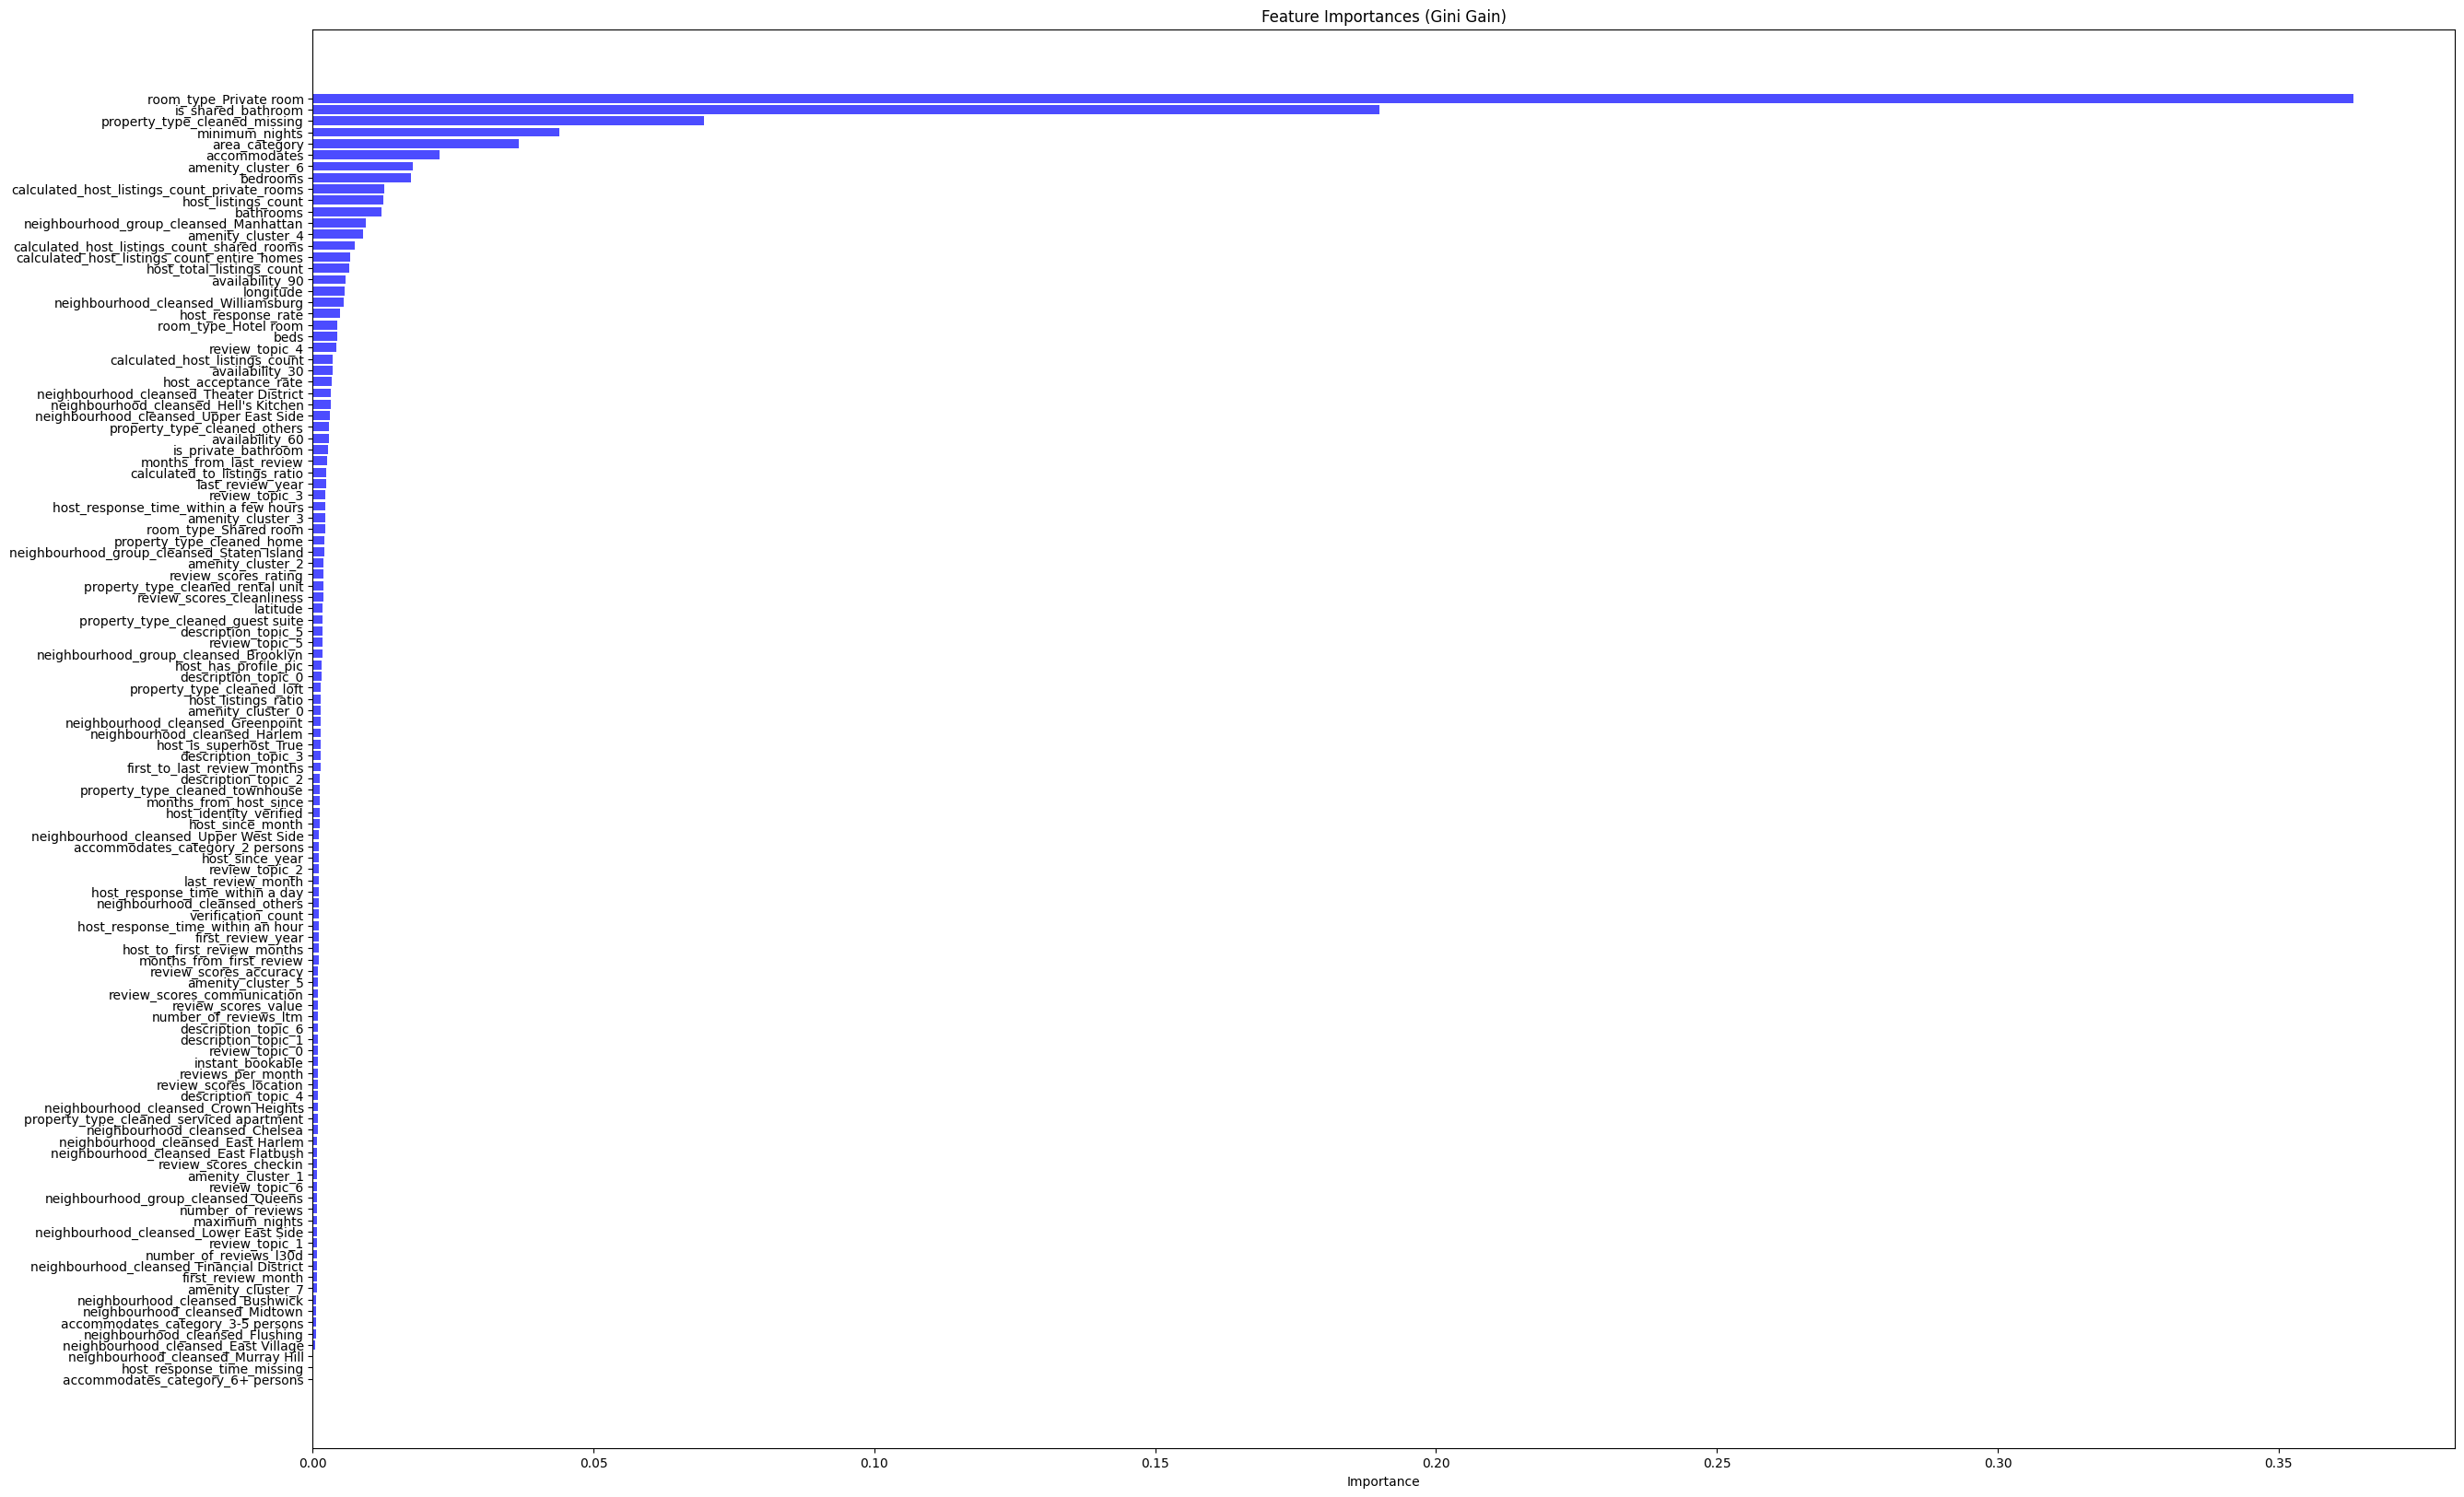

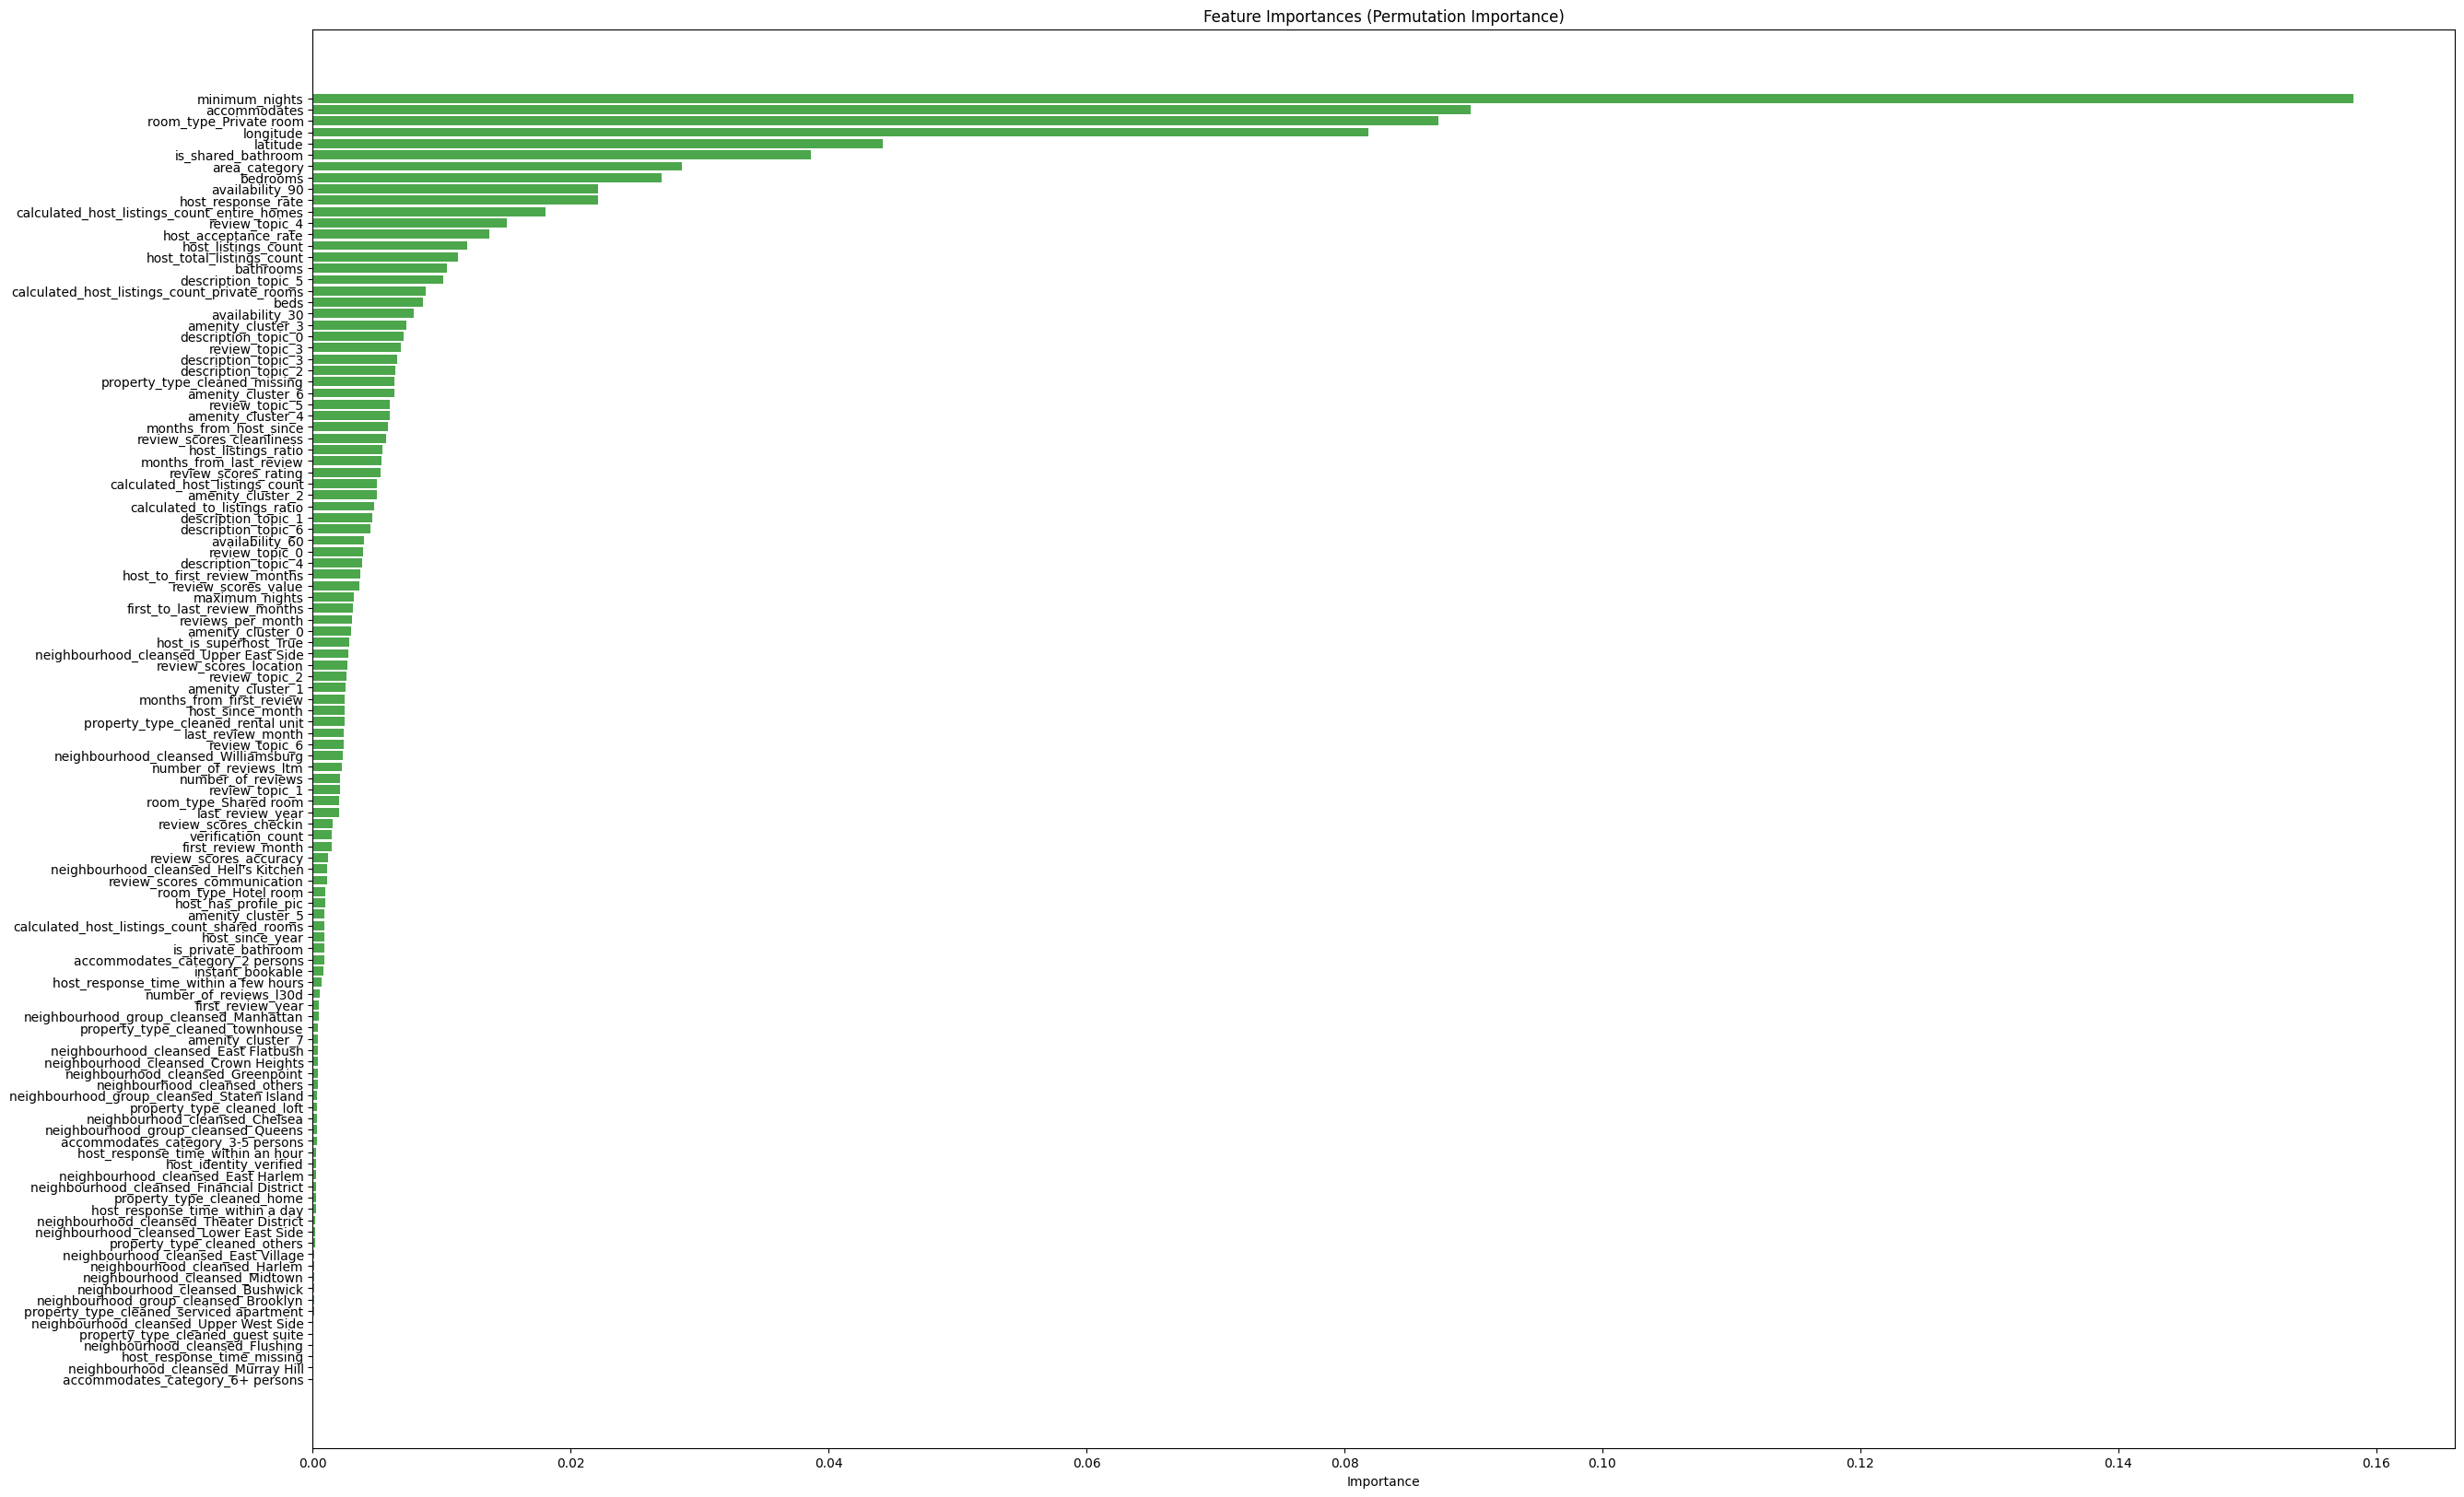

In [27]:
# Separate features and target
target = train_data_dummies['price']
features = train_data_dummies.drop(columns=['price'])

# Train an XGBoost model
model = XGBRegressor(random_state=42, n_estimators=500, learning_rate=0.05)
model.fit(features, target)

# Calculate Gini Gain-based feature importance
gini_importance = model.feature_importances_

# Calculate Permutation Importance
perm_importance = permutation_importance(model, features, target, n_repeats=10, random_state=42)

# Sort by Gini gain importance
sorted_idx_gini = np.argsort(gini_importance)[::-1]
features_sorted_gini = features.columns[sorted_idx_gini]
gini_sorted = gini_importance[sorted_idx_gini]

# Sort by Permutation Importance
sorted_idx_perm = perm_importance.importances_mean.argsort()[::-1]
features_sorted_perm = features.columns[sorted_idx_perm]
perm_sorted = perm_importance.importances_mean[sorted_idx_perm]

# Plot Gini Gain Feature Importance
plt.figure(figsize=(30, 20))
plt.barh(features_sorted_gini, gini_sorted, color="blue", alpha=0.7)
plt.gca().invert_yaxis()
plt.title("Feature Importances (Gini Gain)")
plt.xlabel("Importance")
plt.show()

# Plot Permutation Importance
plt.figure(figsize=(30, 20))
plt.barh(features_sorted_perm, perm_sorted, color="green", alpha=0.7)
plt.gca().invert_yaxis()
plt.title("Feature Importances (Permutation Importance)")
plt.xlabel("Importance")
plt.show()


In [28]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import label_binarize, LabelEncoder

# Assuming train_data_dummies is already loaded
# Extract 'price' as target and binarize it
target = train_data_dummies['price']
features = train_data_dummies.drop(columns=['price'])

# Encode target into numeric classes if not already encoded
le = LabelEncoder()
target_encoded = le.fit_transform(target)

# Binarize the target for multiclass OvR
target_binarized = label_binarize(target_encoded, classes=range(len(le.classes_)))

# Select a specific class (e.g., Class 0)
class_index = 0  # Change this index for other classes
class_name = le.classes_[class_index]

# Initialize the plot
plt.figure(figsize=(40, 30))

# Loop through each feature and plot ROC curve for the selected class
for feature in features.columns:
    feature_values = features[feature]

    # Handle missing values by filling with the median or another method
    if feature_values.isna().any():
        feature_values = feature_values.fillna(feature_values.median())

    # Handle non-numeric features by encoding them
    if not pd.api.types.is_numeric_dtype(feature_values):
        feature_values = pd.factorize(feature_values)[0]

    # Compute ROC curve and AUC for the selected class
    fpr, tpr, _ = roc_curve(target_binarized[:, class_index], feature_values)
    roc_auc = auc(fpr, tpr)

    # Add the ROC curve to the plot
    plt.plot(fpr, tpr, label=f'{feature} (AUC = {roc_auc:.2f})')

# Finalize the plot
plt.plot([0, 1], [0, 1], 'k--', label='Random chance')  # Diagonal line
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title(f'ROC Curves for All Features (Class: {class_name})')
plt.legend(loc='best', bbox_to_anchor=(1.05, 1))
plt.grid()
plt.tight_layout()
plt.show()


Output hidden; open in https://colab.research.google.com to view.

## 5. Data Split

In [8]:
# Separate features and target from the train dataset
target = train_data_dummies['price']
features = train_data_dummies.drop(columns=['price'])

# Split into training and testing sets (80% train, 20% test)
X_train, X_test, y_train, y_test = train_test_split(
    features, target, test_size=0.2, random_state=42
)
print(f"Training set size: {X_train.shape}, Test set size: {X_test.shape}")

# Initialize the imputer for missing values
imputer = SimpleImputer(strategy='median')

# Impute missing values for train and test sets
X_train = imputer.fit_transform(X_train)
X_test = imputer.transform(X_test)

# Impute missing values for the full training dataset and the true test dataset
X_full_train = imputer.fit_transform(features)  # Full training features
y_full_train = target
X_true_test = imputer.transform(test_data_dummies)  # True test dataset features


Training set size: (12556, 114), Test set size: (3140, 114)


## 6. Model

### 6.1 XGBoost

In [ ]:
# Ensure that X_train and y_train are NumPy arrays
X_train = np.array(X_train)
y_train = np.array(y_train)

# Parameter search range
n_estimators_range = [100, 500, 1000]
learning_rate_range = [0.01, 0.1, 0.5]
max_depth_range = [5, 7, 10]

# Cross-validation setup
kf = KFold(n_splits=5, shuffle=True, random_state=42)

# Store results for visualization
results = []

# Iterate through parameter combinations
for n_estimators in n_estimators_range:
    for learning_rate in learning_rate_range:
        for max_depth in max_depth_range:
            print(f"Processing: n_estimators={n_estimators}, learning_rate={learning_rate}, max_depth={max_depth}")

            rmse_scores = []

            # 5-fold cross-validation
            for train_index, valid_index in kf.split(X_train):
                # Split training and validation sets
                X_train_cv, X_valid_cv = X_train[train_index], X_train[valid_index]
                y_train_cv, y_valid_cv = y_train[train_index], y_train[valid_index]

                # Build the model
                model_xgb = XGBRegressor(
                    n_estimators=n_estimators,
                    learning_rate=learning_rate,
                    max_depth=max_depth,
                    tree_method="hist",  # Use histogram-based method for faster training
                    random_state=42
                )

                # Train the model
                model_xgb.fit(X_train_cv, y_train_cv, eval_set=[(X_valid_cv, y_valid_cv)], verbose=False)

                # Predict on the validation set
                y_pred_cv = model_xgb.predict(X_valid_cv)
                rmse_cv = np.sqrt(mean_squared_error(y_valid_cv, y_pred_cv))
                rmse_scores.append(rmse_cv)

            # Calculate the average RMSE for the current parameter combination
            mean_rmse = np.mean(rmse_scores)
            print(f"  Average RMSE: {mean_rmse:.4f}")

            # Append the result for visualization
            results.append((n_estimators, learning_rate, max_depth, mean_rmse))

# Convert results to a structured format
results = np.array(results)
n_estimators_vals = results[:, 0]
learning_rate_vals = results[:, 1]
max_depth_vals = results[:, 2]
rmse_vals = results[:, 3]

# Find the best parameters and RMSE
best_index = np.argmin(rmse_vals)
best_params = {
    "n_estimators": int(n_estimators_vals[best_index]),
    "learning_rate": learning_rate_vals[best_index],
    "max_depth": int(max_depth_vals[best_index])
}
best_rmse = rmse_vals[best_index]

print("\nOptimization complete.")
print("Best Parameters:")
print(best_params)
print(f"Best RMSE: {best_rmse:.4f}")

# Create an interactive 3D scatter plot with Plotly
fig = go.Figure()

# Add scatter points
fig.add_trace(go.Scatter3d(
    x=n_estimators_vals,
    y=learning_rate_vals,
    z=max_depth_vals,
    mode='markers',
    marker=dict(
        size=8,
        color=rmse_vals,  # Color by RMSE
        colorscale='Viridis',  # Color scale
        colorbar=dict(title="RMSE"),
        opacity=0.8
    )
))

# Set axis labels and title
fig.update_layout(
    scene=dict(
        xaxis_title="n_estimators",
        yaxis_title="learning_rate",
        zaxis_title="max_depth"
    ),
    title="Interactive 3D Visualization of Hyperparameter Search",
    margin=dict(l=0, r=0, b=0, t=40)
)

# Show the plot
fig.show()


In [11]:
# Define the Optuna objective function
def objective(trial):
    # Define hyperparameters to optimize
    param = {
        "n_estimators": trial.suggest_int("n_estimators", 500, 1500),
        "learning_rate": trial.suggest_float("learning_rate", 0.01, 0.2),
        "max_depth": trial.suggest_int("max_depth", 7, 15),
        "subsample": trial.suggest_float("subsample", 0.8, 1.0),
        "colsample_bytree": trial.suggest_float("colsample_bytree", 0.6, 1.0),
        "gamma": trial.suggest_float("gamma", 0.07, 0.1),
        "reg_alpha": trial.suggest_float("reg_alpha", 1, 20),
        "reg_lambda": trial.suggest_float("reg_lambda", 0, 10),
        "min_child_weight": trial.suggest_int("min_child_weight", 1, 10),
        "scale_pos_weight": trial.suggest_float("scale_pos_weight", 1, 2),
        "max_delta_step": trial.suggest_int("max_delta_step", 0, 10),
        "grow_policy": "depthwise",
        "random_state": 42
    }

    # Create XGBoost model
    model_xgb = XGBRegressor(**param)

    # Train the model
    model_xgb.fit(X_train, y_train, eval_set=[(X_test, y_test)], verbose=False)

    # Predict on the validation set and calculate RMSE
    y_pred_xgb = model_xgb.predict(X_test)
    rmse_xgb = np.sqrt(mean_squared_error(y_test, y_pred_xgb))
    return rmse_xgb

# Use Optuna to optimize hyperparameters
study_xgb = optuna.create_study(direction="minimize")
study_xgb.optimize(objective, n_trials=100)  # Run 500 trials for the final submission

# Print the best parameters and RMSE
print("Best parameters (XGBoost):", study_xgb.best_params)
print("Best RMSE (XGBoost):", study_xgb.best_value)


[I 2024-11-27 12:07:17,260] A new study created in memory with name: no-name-0c9db1e2-b488-4865-97fd-3049c5c7d811
[I 2024-11-27 12:07:30,201] Trial 0 finished with value: 0.7047456774595967 and parameters: {'n_estimators': 1487, 'learning_rate': 0.016313718259919528, 'max_depth': 7, 'subsample': 0.959003243746744, 'colsample_bytree': 0.9431618781050795, 'gamma': 0.0965125629649004, 'reg_alpha': 8.607508134664434, 'reg_lambda': 0.44401857413904344, 'min_child_weight': 7, 'scale_pos_weight': 1.7017679753322907, 'max_delta_step': 6}. Best is trial 0 with value: 0.7047456774595967.
[I 2024-11-27 12:07:34,868] Trial 1 finished with value: 0.7262670985650282 and parameters: {'n_estimators': 573, 'learning_rate': 0.1554592463440791, 'max_depth': 12, 'subsample': 0.8099816057085266, 'colsample_bytree': 0.937458291614061, 'gamma': 0.08576270272630011, 'reg_alpha': 7.175334086161237, 'reg_lambda': 9.796977280665692, 'min_child_weight': 9, 'scale_pos_weight': 1.7751547439960909, 'max_delta_step':

Best parameters (XGBoost): {'n_estimators': 1124, 'learning_rate': 0.029246043645704968, 'max_depth': 8, 'subsample': 0.9265040812023361, 'colsample_bytree': 0.7777393761790091, 'gamma': 0.07749608798591799, 'reg_alpha': 1.2683640293961276, 'reg_lambda': 0.47911440834323005, 'min_child_weight': 2, 'scale_pos_weight': 1.0549466823459481, 'max_delta_step': 5}
Best RMSE (XGBoost): 0.6912871893865935


Training model 1...
Training model 2...
Training model 3...
Training model 4...
Training model 5...
Training model 6...
Training model 7...
Training model 8...
Training model 9...
Training model 10...
Training model 11...
Optimal number of models: 5
Minimum RMSE: 0.7352


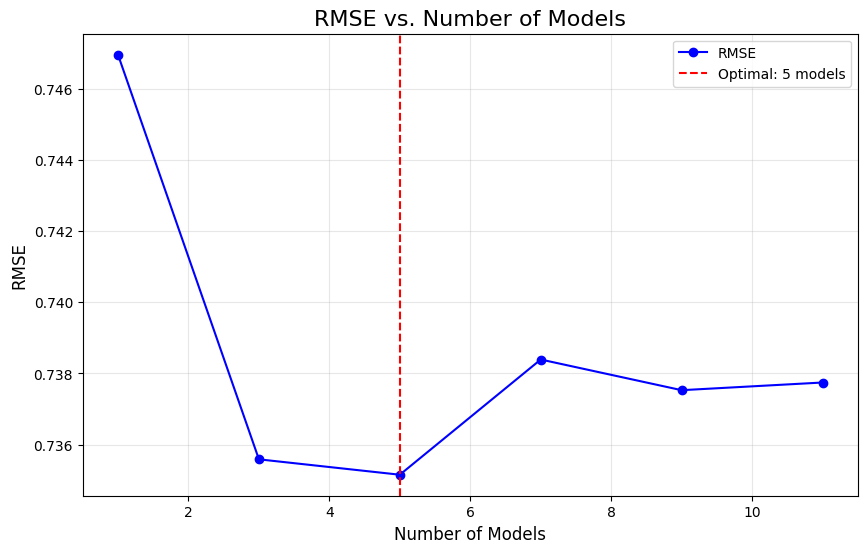

In [12]:
# Retrieve the top 51 trial parameters (51 for final submission)
top_trials_xgb = study_xgb.trials_dataframe().sort_values(by="value").head(11)
counter = 0
models_xgb = []

# Train models using the top 51 trial parameters
for _, trial_row in top_trials_xgb.iterrows():
    counter += 1
    print(f"Training model {counter}...")

    # Extract parameters
    trial_number = int(trial_row["number"])
    best_params_xgb = study_xgb.trials[trial_number].params

    # Create and train the model
    model_xgb = XGBRegressor(**best_params_xgb)
    model_xgb.fit(X_train, y_train, verbose=False)
    models_xgb.append(model_xgb)

# Get predictions from all models
predictions_xgb = np.array([model.predict(X_test) for model in models_xgb])

# Clip predictions to the range [0, 5] and round them
predictions_xgb_clipped = np.round(np.clip(predictions_xgb, 0, 5))

# Initialize the RMSE results list
rmse_results = []

# Compute RMSE for 1, 3, 5, ..., 51 models
for num_models in range(1, 12, 2):  # 1, 3, 5, ..., 51
    # Compute the mode of predictions from the first num_models models
    y_pred_xgb_mode = mode(predictions_xgb_clipped[:num_models], axis=0).mode.squeeze()

    # Ensure y_pred_xgb_mode is a 1D array with the same shape as y_test
    y_pred_xgb_mode = y_pred_xgb_mode.flatten()

    # Compute RMSE and store the result
    rmse_xgb = np.sqrt(mean_squared_error(y_test, y_pred_xgb_mode))
    rmse_results.append((num_models, rmse_xgb))

# Convert results to an array for further processing
rmse_results = np.array(rmse_results)

# Find the number of models that give the minimum RMSE
optimal_index = np.argmin(rmse_results[:, 1])
optimal_models = int(rmse_results[optimal_index, 0])
optimal_rmse = rmse_results[optimal_index, 1]

print(f"Optimal number of models: {optimal_models}")
print(f"Minimum RMSE: {optimal_rmse:.4f}")

# Plot RMSE vs. number of models
plt.figure(figsize=(10, 6))
plt.plot(rmse_results[:, 0], rmse_results[:, 1], marker='o', linestyle='-', color='blue', label='RMSE')
plt.axvline(optimal_models, color='red', linestyle='--', label=f'Optimal: {optimal_models} models')
plt.title('RMSE vs. Number of Models', fontsize=16)
plt.xlabel('Number of Models', fontsize=12)
plt.ylabel('RMSE', fontsize=12)
plt.grid(alpha=0.3)
plt.legend()
plt.show()


### 6.2 SVM

In [ ]:
# Standardize the features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)
X_train_scaled = np.array(X_train_scaled)
y_train = np.array(y_train)
# Define the parameter grid for hyperparameter tuning
param_grid = {
    'C': [0.1, 1, 10, 100],            # Regularization parameter
    'epsilon': [0.01, 0.1, 0.2, 0.5],  # Epsilon in the epsilon-SVR model
    'kernel': ['rbf']        # Kernel types to consider
}

# Set up cross-validation
kf = KFold(n_splits=5, shuffle=True, random_state=42)

# Initialize variables to store the best result and all results for visualization
best_rmse = float('inf')
best_params = None
results = []  # Store all combinations for 3D visualization

# Manual Grid Search
print("Starting manual grid search...")
for kernel in param_grid['kernel']:
    for C in param_grid['C']:
        for epsilon in param_grid['epsilon']:
            print(f"Training with kernel={kernel}, C={C}, epsilon={epsilon}")

            rmse_scores = []
            for train_index, val_index in kf.split(X_train_scaled):
                # Split data into training and validation sets
                X_train_cv, X_val_cv = X_train_scaled[train_index], X_train_scaled[val_index]
                y_train_cv, y_val_cv = y_train[train_index], y_train[val_index]

                # Train the model
                svr = SVR(kernel=kernel, C=C, epsilon=epsilon)
                svr.fit(X_train_cv, y_train_cv)

                # Predict and calculate RMSE
                y_val_pred = svr.predict(X_val_cv)
                rmse = np.sqrt(mean_squared_error(y_val_cv, y_val_pred))
                rmse_scores.append(rmse)

            # Calculate mean RMSE across folds
            mean_rmse = np.mean(rmse_scores)
            print(f"Mean RMSE: {mean_rmse:.4f}")

            # Store the results for 3D visualization
            results.append((kernel, C, epsilon, mean_rmse))

            # Update best parameters if current RMSE is better
            if mean_rmse < best_rmse:
                best_rmse = mean_rmse
                best_params = {'kernel': kernel, 'C': C, 'epsilon': epsilon}

# Train the final model with the best parameters on the full training set
print("\nTraining final model with best parameters...")
print(f"Best Parameters: {best_params}")
svr = SVR(**best_params)
svr.fit(X_train_scaled, y_train)

# Predict on the test set
y_pred = svr.predict(X_test_scaled)

# Calculate RMSE on the test set
final_rmse = np.sqrt(mean_squared_error(y_test, y_pred))
print(f"Final Test RMSE: {final_rmse:.4f}")

# 3D Plot of RMSE values
results = np.array(results)
kernels = results[:, 0]
Cs = results[:, 1].astype(float)
epsilons = results[:, 2].astype(float)
rmses = results[:, 3].astype(float)

# Convert kernel types to numeric values for 3D plotting
kernel_map = {'linear': 0, 'rbf': 1}
kernel_numeric = np.array([kernel_map[k] for k in kernels])

fig = go.Figure()

# Add scatter points
fig.add_trace(go.Scatter3d(
    x=Cs,
    y=epsilons,
    z=kernel_numeric,
    mode='markers',
    marker=dict(
        size=8,
        color=rmses,  # Color by RMSE
        colorscale='Viridis',  # Color scale
        colorbar=dict(title="RMSE"),
        opacity=0.8
    )
))

# Set axis labels and title
fig.update_layout(
    scene=dict(
        xaxis_title="C (Regularization Parameter)",
        yaxis_title="Epsilon",
        zaxis_title="Kernel (0=Linear, 1=RBF)"
    ),
    title="3D Visualization of Grid Search Results",
    margin=dict(l=0, r=0, b=0, t=40)
)

# Show the plot
fig.show()


## 7. Test and submission

In [26]:
# Retrieve the top trials for XGBoost
top_trials_xgb = study_xgb.trials_dataframe().sort_values(by="value").head(3)

# Use a bagging approach to retrain XGBoost models
models_xgb_test = []
for _, trial_row in top_trials_xgb.iterrows():
    # Extract parameters
    trial_number = int(trial_row["number"])
    best_params_xgb = study_xgb.trials[trial_number].params

    # Create and train the model
    model_xgb = XGBRegressor(**best_params_xgb)
    model_xgb.fit(X_full_train, y_full_train, verbose=False)
    models_xgb_test.append(model_xgb)

# Make predictions on the test set
predictions_xgb_test = np.array([model.predict(X_true_test) for model in models_xgb_test])
# Clip predictions to the range [0,5] and round to the nearest integer
predictions_xgb_clipped = np.round(np.clip(predictions_xgb_test, 0, 5))  # (10, n_samples)
# Take the mode (most common value) across models for each sample
y_pred_xgb_mode = mode(predictions_xgb_clipped, axis=0).mode.squeeze()  # Remove unnecessary dimensions
# Ensure `y_pred_xgb_mode` is a 1D array and matches the shape of `y_test`
y_pred_xgb_mode = y_pred_xgb_mode.flatten()
# Final predictions for the test set
y_pred_xgb_test = y_pred_xgb_mode
# Load the test dataset
test_data = pd.read_csv('/content/drive/My Drive/Colab Notebooks/final_project/test_LDA.csv', parse_dates=['host_since', 'first_review', 'last_review'])
# Assuming `test_data['id']` is loaded, prepare the submission file
submission = pd.DataFrame({
    'id': test_data['id'],  # Unique identifier for the test set
    'price': y_pred_xgb_test  # Predictions from the model
})

# Save the results as an Excel file
submission.to_excel('/content/drive/My Drive/Colab Notebooks/final_project/submission.xlsx', index=False)
print("The submission file has been saved as submission.xlsx")


The submission file has been saved as submission.xlsx
